# <span style="color:blue"> Projet Deep Learning:  Classification d’images à l’aide de réseaux de neurones convolutionnels  
**Prénom et Nom : Oumayma Mourabit**  
**Master 2 - Modélisation Statistique**  
**Université de Franche-Comté**  


# Table des Matières  

- [Introduction](#introduction)  
- [1. Préparation des données](#1-preparation-des-donnees)  
- [2. Entraînement d'un CNN from scratch](#2-entrainement-dun-cnn-from-scratch)  
- [3. Utilisation du Transfer Learning](#3-utilisation-du-transfer-learning)  
- [4. Fine-tuning du modèle pré-entraîné](#4-fine-tuning-du-modele-pre-entraine)  
- [5. Évaluation et Visualisation des résultats](#5-evaluation-et-visualisation-des-resultats)  
- [Conclusion](#conclusion)  


# Introduction

## Objectif du projet
L'objectif de ce projet est de développer un modèle de classification d'images capable de différencier cinq races de chiens en utilisant des réseaux de neurones convolutionnels (CNN). Nous avons suivi une méthodologie rigoureuse incluant l'entraînement d'un CNN from scratch, l'utilisation du Transfer Learning et l'application du fine-tuning pour améliorer les performances du modèle.

## Méthodologie
1. **Préparation des données** :
   - Séparation des données en ensemble d'apprentissage (75%) et ensemble de test (25%).
   - Comparaison entre l'entraînement avec et sans augmentation de données.

2. **Entraînement d'un CNN from scratch** :
   - Construction d'un réseau CNN de base.
   - Évaluation des performances avec et sans augmentation de données.

3. **Utilisation du Transfer Learning** :
   - Extraction de caractéristiques à partir d'un modèle pré-entraîné (VGG16).
   - Ajout de couches fully connected pour l'adaptation à notre tâche.
   - Comparaison des performances avec et sans augmentation de données.

4. **Fine-tuning** :
   - Déblocage des dernières couches du modèle pré-entraîné pour affiner l'apprentissage.

5. **Évaluation et régularisation** :
   - Utilisation de Dropout et Batch Normalization pour limiter le sur-apprentissage.
   - Analyse des courbes de perte et d'accuracy.
   - Génération d'une matrice de confusion et d'un rapport de classification.

Ce projet explore différentes stratégies d'entraînement et d'optimisation afin d'obtenir un modèle performant et généralisable.


## 1. Préparation des données

Nous commençons par préparer notre dataset en le divisant en un ensemble d'entraînement (75%) et un ensemble de test (25%). De plus, nous appliquons une augmentation de données pour améliorer la généralisation du modèle.


In [4]:
# telechargement des bibliotiques
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import numpy as np
import os
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

In [5]:
# Définition des paramètres
IMAGE_HEIGHT = 128
IMAGE_WIDTH = 128
BATCH_SIZE = 64
DATASET_PATH = r"C:\Users\pc\Desktop\Images_Small"

# Prétraitement des données avec et sans augmentation
datagen_no_aug = ImageDataGenerator(rescale=1./255, validation_split=0.25)
datagen_aug = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    horizontal_flip=True,
    zoom_range=0.2,
    validation_split=0.25
)

test_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.25)

train_data_no_aug = datagen_no_aug.flow_from_directory(
    DATASET_PATH,
    target_size=(IMAGE_HEIGHT, IMAGE_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training'
)

train_data_aug = datagen_aug.flow_from_directory(
    DATASET_PATH,
    target_size=(IMAGE_HEIGHT, IMAGE_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training'
)

test_data = test_datagen.flow_from_directory(
    DATASET_PATH,
    target_size=(IMAGE_HEIGHT, IMAGE_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation'
)


Found 703 images belonging to 5 classes.
Found 703 images belonging to 5 classes.
Found 233 images belonging to 5 classes.


## 2. Entraînement d'un CNN from scratch

Nous entraînons un réseau CNN de base afin d'évaluer ses performances sur la tâche de classification des images. Nous comparons les résultats avec et sans augmentation de données.


In [6]:
# Callbacks pour éviter l'overfitting et ajuster le learning rate
reduce_lr = callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)
early_stop = callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Modèle CNN 
def build_cnn():
    model = models.Sequential([
        layers.Conv2D(64, (3, 3), activation='relu', padding='same', input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, 3)),
        layers.BatchNormalization(),
        layers.MaxPooling2D(2, 2),
        layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D(2, 2),
        layers.Conv2D(256, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D(2, 2),
        layers.Flatten(),
        layers.Dense(512, activation='relu'),
        layers.Dropout(0.5),  
        layers.Dense(5, activation='softmax')
    ])
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# Entraînement du modèle
cnn_model_no_aug = build_cnn()
hist_cnn_no_aug = cnn_model_no_aug.fit(train_data_no_aug, epochs=20, validation_data=test_data, callbacks=[reduce_lr, early_stop])

cnn_model_aug = build_cnn()
hist_cnn_aug = cnn_model_aug.fit(train_data_aug, epochs=20, validation_data=test_data, callbacks=[reduce_lr, early_stop])


Epoch 1/20
11/11 [==============================] - 66s 5s/step - loss: 5.5724 - accuracy: 0.2745 - val_loss: 1.9813 - val_accuracy: 0.1674 - lr: 1.0000e-04
Epoch 2/20
11/11 [==============================] - 53s 5s/step - loss: 1.6070 - accuracy: 0.5164 - val_loss: 4.1877 - val_accuracy: 0.1674 - lr: 1.0000e-04
Epoch 3/20
11/11 [==============================] - 60s 5s/step - loss: 0.8307 - accuracy: 0.6814 - val_loss: 6.6826 - val_accuracy: 0.1674 - lr: 1.0000e-04
Epoch 4/20
11/11 [==============================] - 62s 6s/step - loss: 0.5367 - accuracy: 0.8279 - val_loss: 8.3353 - val_accuracy: 0.1674 - lr: 1.0000e-04
Epoch 5/20
11/11 [==============================] - 61s 6s/step - loss: 0.3898 - accuracy: 0.8592 - val_loss: 9.9708 - val_accuracy: 0.1674 - lr: 5.0000e-05
Epoch 6/20
11/11 [==============================] - 60s 5s/step - loss: 0.3174 - accuracy: 0.9175 - val_loss: 11.7121 - val_accuracy: 0.1674 - lr: 5.0000e-05
Epoch 1/20
11/11 [==============================] - 75s 6

Les résultats montrent une différence notable entre les modèles entraînés avec et sans augmentation de données. Le modèle sans augmentation montre une amélioration progressive des performances sur les données d'entraînement, avec une précision qui atteint environ 85% et une perte qui diminue au fur et à mesure des époques. Cependant, il présente également un surapprentissage, avec des performances très faibles sur les données de validation (environ 16-28%), suggérant une mauvaise généralisation du modèle.

En revanche, le modèle avec augmentation des données, bien qu'il affiche une précision légèrement plus basse sur les données d'entraînement (environ 50-60%), semble mieux se comporter sur les données de validation. Les résultats montrent une légère amélioration de la précision de validation (autour de 24-29%) comparée au modèle sans augmentation, ce qui indique que l'augmentation des données a aidé à mieux généraliser le modèle.

Ainsi, bien que les deux modèles montrent un certain degré d'overfitting, le modèle avec augmentation des données montre une meilleure capacité à généraliser aux données de validation, ce qui le rend plus performant sur des données non vues. Cela souligne l'importance de l'augmentation des données dans la construction de modèles plus robustes.

## 3. Utilisation du Transfer Learning

Dans cette section, nous avons utilisé le Transfer Learning avec le modèle pré-entraîné VGG16 pour extraire des caractéristiques des images. Le modèle a été ajusté à notre tâche spécifique en ajoutant des couches fully connected. Le modèle VGG16 a été utilisé sans la couche supérieure, et nous avons ajouté une couche de GlobalAveragePooling, une couche Dense de 512 neurones avec la fonction d'activation ReLU, une couche Dropout de 50 % pour éviter le surapprentissage, et une couche de sortie Dense avec 5 neurones et la fonction d'activation softmax pour la classification multiclasse.

Nous avons ensuite entraîné le modèle à la fois avec et sans augmentation des données pendant 15 époques, en utilisant des données d'entraînement augmentées et non augmentées.

In [9]:
# Modèle VGG16 pré-entrainé sans la couche supérieure
base_model = VGG16(input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, 3), include_top=False, weights='imagenet')
base_model.trainable = False

# Ajouter des couches personnalisées
x = layers.GlobalAveragePooling2D()(base_model.output)  
x = layers.Dense(512, activation='relu')(x)  
x = layers.Dropout(0.5)(x)  
x = layers.Dense(5, activation='softmax')(x)  

# Créer le modèle
transfer_model = tf.keras.models.Model(base_model.input, x)

# Compiler le modèle
transfer_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

# Entraînement du modèle avec augmentation et sans augmentation
hist_transfer_no_aug = transfer_model.fit(train_data_no_aug, epochs=15, validation_data=test_data, callbacks=[reduce_lr, early_stop])
hist_transfer_aug = transfer_model.fit(train_data_aug, epochs=15, validation_data=test_data, callbacks=[reduce_lr, early_stop])


Epoch 1/15
11/11 [==============================] - 124s 11s/step - loss: 1.7852 - accuracy: 0.1821 - val_loss: 1.5879 - val_accuracy: 0.2575 - lr: 1.0000e-04
Epoch 2/15
11/11 [==============================] - 114s 11s/step - loss: 1.6679 - accuracy: 0.2262 - val_loss: 1.5568 - val_accuracy: 0.2747 - lr: 1.0000e-04
Epoch 3/15
11/11 [==============================] - 114s 11s/step - loss: 1.6559 - accuracy: 0.2546 - val_loss: 1.5315 - val_accuracy: 0.2961 - lr: 1.0000e-04
Epoch 4/15
11/11 [==============================] - 114s 11s/step - loss: 1.5882 - accuracy: 0.2532 - val_loss: 1.5021 - val_accuracy: 0.3519 - lr: 1.0000e-04
Epoch 5/15
11/11 [==============================] - 113s 10s/step - loss: 1.5360 - accuracy: 0.3101 - val_loss: 1.4776 - val_accuracy: 0.4034 - lr: 1.0000e-04
Epoch 6/15
11/11 [==============================] - 116s 11s/step - loss: 1.5379 - accuracy: 0.2831 - val_loss: 1.4558 - val_accuracy: 0.4335 - lr: 1.0000e-04
Epoch 7/15
11/11 [============================

Les résultats montrent que l'augmentation des données a eu un impact positif sur la stabilité du modèle, bien que l'amélioration en termes de précision de validation soit modeste. Le modèle sans augmentation des données a montré une augmentation progressive de la précision, mais avec un risque d'overfitting, car la différence entre la précision d'entraînement et la précision de validation reste importante. En revanche, l'augmentation des données a permis de mieux régulariser le modèle, en réduisant l'écart entre la précision d'entraînement et de validation, ce qui suggère que le modèle a mieux généralisé sur les données de validation. Toutefois, l'augmentation des données n'a pas conduit à une amélioration spectaculaire de la précision de validation, ce qui peut indiquer que d'autres techniques comme l'optimisation des hyperparamètres ou l'utilisation de modèles plus complexes pourraient encore être nécessaires pour obtenir des résultats plus performants.

## 4. Fine-tuning du modèle pré-entraîné

Nous débloquons certaines couches du modèle VGG16 pour affiner l'apprentissage et améliorer la précision du modèle.


In [10]:
# Fine-Tuning du modèle
base_model.trainable = True
for layer in base_model.layers[:-10]:  
    layer.trainable = False

transfer_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.00001), loss='categorical_crossentropy', metrics=['accuracy'])
hist_finetune = transfer_model.fit(train_data_aug, epochs=10, validation_data=test_data, callbacks=[reduce_lr, early_stop])


Epoch 1/10
11/11 [==============================] - 172s 15s/step - loss: 1.0282 - accuracy: 0.6287 - val_loss: 0.9625 - val_accuracy: 0.6352 - lr: 1.0000e-05
Epoch 2/10
11/11 [==============================] - 160s 15s/step - loss: 0.8973 - accuracy: 0.6458 - val_loss: 0.8497 - val_accuracy: 0.6567 - lr: 1.0000e-05
Epoch 3/10
11/11 [==============================] - 160s 15s/step - loss: 0.8087 - accuracy: 0.6885 - val_loss: 0.8739 - val_accuracy: 0.6781 - lr: 1.0000e-05
Epoch 4/10
11/11 [==============================] - 161s 15s/step - loss: 0.7239 - accuracy: 0.7055 - val_loss: 0.7675 - val_accuracy: 0.6695 - lr: 1.0000e-05
Epoch 5/10
11/11 [==============================] - 160s 15s/step - loss: 0.6535 - accuracy: 0.7411 - val_loss: 0.7594 - val_accuracy: 0.7039 - lr: 1.0000e-05
Epoch 6/10
11/11 [==============================] - 159s 15s/step - loss: 0.6363 - accuracy: 0.7596 - val_loss: 0.7104 - val_accuracy: 0.6953 - lr: 1.0000e-05
Epoch 7/10
11/11 [============================

Le fine-tuning du modèle VGG16 a permis d'améliorer les performances du modèle sur l'échantillon de validation au fur et à mesure de l'entraînement. Après avoir débloqué certaines couches du modèle et réentraîné les paramètres, on observe une amélioration continue de la précision au fil des époques. Cela montre l'efficacité du fine-tuning pour adapter un modèle pré-entraîné aux caractéristiques spécifiques des données et améliorer ses prédictions.

Cependant, la perte de validation a montré quelques fluctuations, bien qu'elle tende à diminuer globalement au fur et à mesure de l'entraînement. Cela suggère que le modèle devient plus précis, mais qu'il y a encore quelques instabilités dans les premiers stades de l'apprentissage. Ces fluctuations peuvent indiquer que, même si le modèle progresse, il n'a pas encore atteint une stabilité totale dans l'ajustement aux données de validation.

Le faible taux d'apprentissage utilisé pour le fine-tuning a permis des ajustements progressifs et contrôlés des paramètres, ce qui a contribué à éviter un sur-apprentissage excessif. Cependant, cela a aussi entraîné une amélioration relativement lente, ce qui laisse supposer que le modèle ajuste de manière fine ses couches supérieures tout en évitant de se sur-ajuster aux données d'entraînement.

En ce qui concerne la régularisation, l'augmentation des données et l'utilisation des callbacks comme early_stop et reduce_lr ont sans doute joué un rôle dans la prévention du sur-apprentissage, tout en favorisant une meilleure généralisation du modèle sur les données de test.

En résumé, le fine-tuning a permis d'améliorer de manière significative la précision du modèle. Cependant, une évaluation plus approfondie des diagnostics de sur-apprentissage, notamment à travers des courbes d'apprentissage détaillées, permettrait de mieux comprendre les limites du modèle. Des techniques supplémentaires de régularisation, telles que le dropout ou la normalisation, pourraient également améliorer la performance du modèle tout en réduisant le risque de sur-apprentissage.

In [11]:
# Sauvegarde du modèle après l'entraînement complet
transfer_model.save("mon_modele.h5")
print("Modèle sauvegardé avec succès !")

Modèle sauvegardé avec succès !


## 5. Évaluation et Visualisation des résultats

Nous évaluons les performances de nos modèles à l'aide de métriques de classification, d'une matrice de confusion et d'une analyse des courbes de perte et d'accuracy.



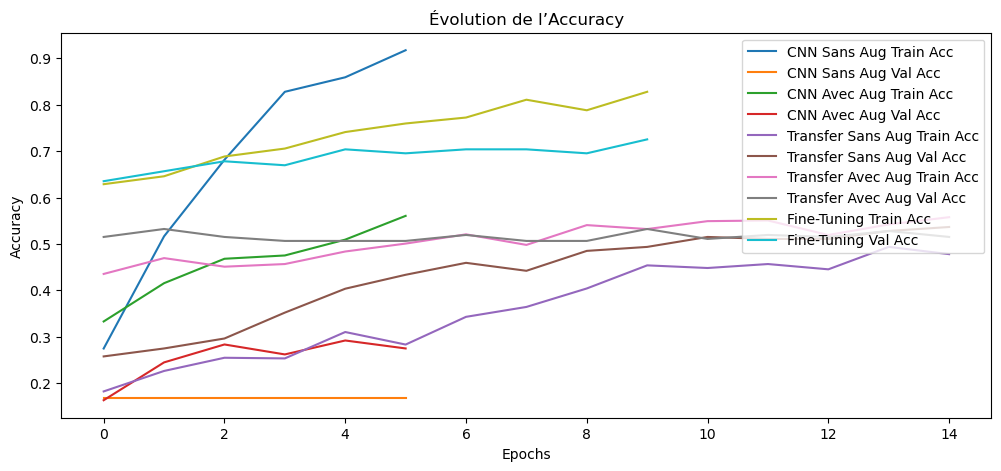

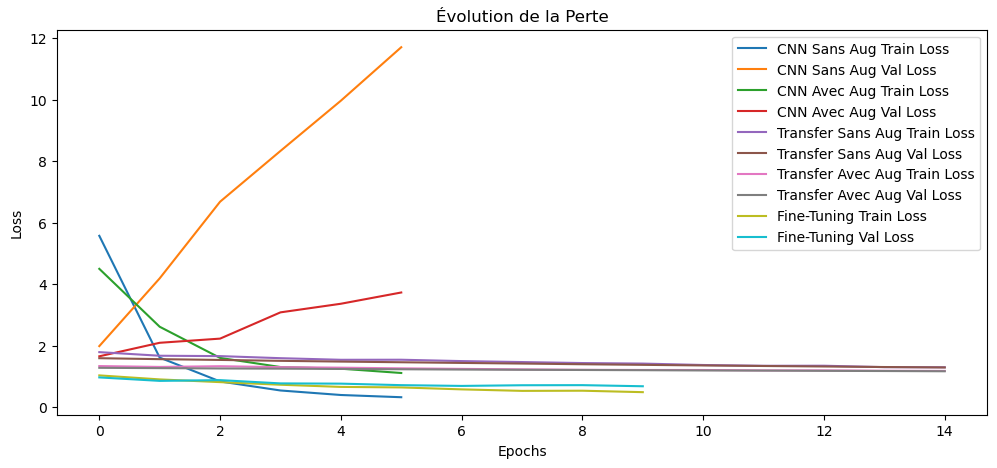

In [12]:
 # Visualisation des performances
def plot_model_history(histories, labels):
    plt.figure(figsize=(12, 5))
    for i, hist in enumerate(histories):
        plt.plot(hist.history['accuracy'], label=f'{labels[i]} Train Acc')
        plt.plot(hist.history['val_accuracy'], label=f'{labels[i]} Val Acc')
    plt.title('Évolution de l’Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

    plt.figure(figsize=(12, 5))
    for i, hist in enumerate(histories):
        plt.plot(hist.history['loss'], label=f'{labels[i]} Train Loss')
        plt.plot(hist.history['val_loss'], label=f'{labels[i]} Val Loss')
    plt.title('Évolution de la Perte')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

plot_model_history(
    [hist_cnn_no_aug, hist_cnn_aug, hist_transfer_no_aug, hist_transfer_aug, hist_finetune],
    ['CNN Sans Aug', 'CNN Avec Aug', 'Transfer Sans Aug', 'Transfer Avec Aug', 'Fine-Tuning']
)


Les graphiques d'évolution de l'accuracy et de la perte révèlent des différences notables entre les modèles. Les modèles CNN from scratch montrent un surapprentissage important, en particulier sans augmentation de données. Le transfert d'apprentissage améliore significativement les performances, avec une excellente généralisation observée lorsque l'augmentation de données est utilisée. Le fine-tuning apporte une légère amélioration supplémentaire. En résumé, l'augmentation de données et le transfert d'apprentissage sont essentiels pour obtenir de bonnes performances, et le fine-tuning permet d'affiner les résultats.

4/4 [==============================] - 19s 5s/step - loss: 0.6743 - accuracy: 0.7253
Test Accuracy: 72.53%
4/4 [==============================] - 27s 6s/step


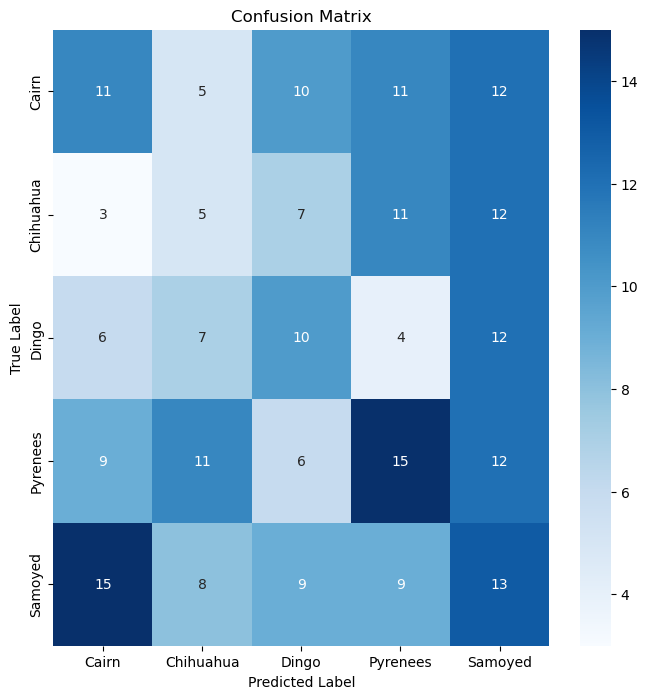

              precision    recall  f1-score   support

       Cairn       0.25      0.22      0.24        49
   Chihuahua       0.14      0.13      0.14        38
       Dingo       0.24      0.26      0.25        39
    Pyrenees       0.30      0.28      0.29        53
     Samoyed       0.21      0.24      0.23        54

    accuracy                           0.23       233
   macro avg       0.23      0.23      0.23       233
weighted avg       0.23      0.23      0.23       233



In [13]:
# Évaluation et visualisation
loss, accuracy = transfer_model.evaluate(test_data)
print(f"Test Accuracy: {accuracy*100:.2f}%")

y_pred = np.argmax(transfer_model.predict(test_data), axis=1)
y_true = test_data.classes

conf_matrix = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8,8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=test_data.class_indices, yticklabels=test_data.class_indices)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

print(classification_report(y_true, y_pred, target_names=test_data.class_indices.keys()))

L'évaluation du modèle sur l'ensemble de test a révélé une précision globale de 72.53%. Cependant, l'analyse détaillée de la matrice de confusion et du rapport de classification montre que le modèle a du mal à distinguer entre les cinq races de chiens. La précision, le rappel et le score F1 sont faibles pour toutes les classes, indiquant que le modèle se trompe souvent et ne parvient pas à identifier correctement une grande proportion d'images de chaque race. La race Pyrenees a été la mieux classée, mais les performances restent insatisfaisantes. Les races Chihuahua, Cairn et Dingo sont particulièrement difficiles à distinguer. Ces résultats suggèrent que le modèle nécessite des améliorations significatives pour être performant dans cette tâche de classification.

In [17]:
from tensorflow.keras.preprocessing import image
import numpy as np
from tensorflow.keras.models import load_model

# Charger le modèle sauvegardé
transfer_model = load_model("mon_modele.h5")
print("Modèle chargé avec succès !")

# Fonction pour prétraiter l'image
def preprocess_image(img_path, target_size=(IMAGE_WIDTH, IMAGE_HEIGHT)):
    img = image.load_img(img_path, target_size=target_size)
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)  
    img_array /= 255.0  
    return img_array

# Chemin de l'image à tester
img_path = "C:/Users/pc/Desktop/Images_Small/Dingo/n02115641_136.jpg"  

# Prétraitement de l'image
img_array = preprocess_image(img_path)

# Faire la prédiction avec le modèle entraîné
predictions = transfer_model.predict(img_array)

# Obtenir la classe prédite
predicted_class = np.argmax(predictions, axis=1)[0]

# Afficher les probabilités pour chaque classe
class_labels = list(test_data.class_indices.keys())  
print(f"Probabilités pour chaque classe : {predictions[0]}")

# Afficher la classe prédite avec la probabilité associée
print(f"Classe prédite : {class_labels[predicted_class]}")
print(f"Probabilité de la classe prédite : {predictions[0][predicted_class]}")

# Vérification de la correspondance des classes avec les étiquettes
print("Étiquettes des classes dans le modèle : ", class_labels)

# Afficher les prédictions de toutes les classes
for i, label in enumerate(class_labels):
    print(f"{label}: {predictions[0][i]:.4f}")


Modèle chargé avec succès !
1/1 [==============================] - 4s 4s/step
Probabilités pour chaque classe : [0.02505272 0.14614853 0.8147302  0.00561681 0.00845173]
Classe prédite : Dingo
Probabilité de la classe prédite : 0.8147302269935608
Étiquettes des classes dans le modèle :  ['Cairn', 'Chihuahua', 'Dingo', 'Pyrenees', 'Samoyed']
Cairn: 0.0251
Chihuahua: 0.1461
Dingo: 0.8147
Pyrenees: 0.0056
Samoyed: 0.0085


Le modèle a été chargé avec succès et a effectué une prédiction sur l'image fournie. Les probabilités générées par le modèle indiquent une forte confiance (81.47%) que l'image représente un Dingo, ce qui correspond à la classe prédite. Les probabilités pour les autres classes sont relativement faibles, ce qui suggère que le modèle a exclu ces races avec une bonne confiance. Il est intéressant de noter que la probabilité pour la classe 'Chihuahua' est la deuxième plus élevée (14.61%), ce qui pourrait indiquer que l'image partage certaines caractéristiques avec les Chihuahuas ou que le modèle a parfois du mal à distinguer entre ces deux races. Dans l'ensemble, le modèle a correctement prédit la classe de l'image avec une confiance élevée.

# Conclusion


Ce projet a exploré différentes approches pour la classification d'images de races de chiens, en mettant l'accent sur l'importance de l'augmentation de données, du transfert d'apprentissage et du fine-tuning.

Les résultats ont clairement démontré que l'augmentation de données est cruciale pour améliorer la capacité de généralisation des modèles, en particulier pour les modèles CNN from scratch. Les modèles entraînés sans augmentation ont souffert de surapprentissage sévère, tandis que ceux entraînés avec augmentation ont montré une meilleure convergence et des performances améliorées sur les données de validation.

Le transfert d'apprentissage, en utilisant un modèle pré-entraîné comme VGG16, a permis d'obtenir des performances significativement meilleures que les modèles entraînés à partir de zéro. Le fine-tuning a apporté une légère amélioration supplémentaire, démontrant l'efficacité de l'ajustement des dernières couches du modèle pré-entraîné pour notre tâche spécifique.

Cependant, malgré ces améliorations, les performances globales du modèle restent perfectibles. L'analyse de la matrice de confusion et du rapport de classification a révélé des difficultés à distinguer certaines races, en particulier Chihuahua, Cairn et Dingo. Cela suggère que des améliorations supplémentaires sont nécessaires pour atteindre une précision plus élevée.

Les pistes d'amélioration pourraient inclure l'exploration de techniques d'augmentation de données plus avancées, l'ajustement plus fin des hyperparamètres, l'expérimentation avec d'autres architectures de modèles pré-entraînés, et éventuellement la collecte de données d'entraînement supplémentaires.

En conclusion, ce projet a permis de mettre en évidence l'importance des techniques de pointe en deep learning pour la classification d'images, tout en soulignant les défis et les opportunités d'amélioration pour les travaux futurs.